# Fritsch Solition
Author: Joshua D. JOHN
Date: 2024/07/21

This is an implementation of Fritsch Solitons. What I am calling the Fritsch method is a way to create dark solitons at arbitrary position and velocity by simultaneously engineering the amplitude and phase of the condensate wave function. This is introduced as a better approach compared to the technique demonstrated before, which manipulated the condensate phase only.

* Fritsch, A.R., Lu, M., Reid, G., Piñeiro, A., & Spielman, I.B. (2020). _Creating solitons with controllable and near-zero velocity in Bose-Einstein condensates._ Physical review. A, 101 5.


In [1]:
from oqtant.schemas.quantum_matter import QuantumMatterFactory, QuantumMatter
from IPython.display import HTML
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d


qmf = QuantumMatterFactory()
qmf.get_login()

Auth(children=(HBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x12\x00\x00\x00\xc…

In [2]:
qmf.get_client()

Job Limits:
╒═══════════════╤═══════════════════╤════════════════════╤════════════════════╕
│   Daily Limit │   Daily Remaining │   Standard Credits │   Priority Credits │
╞═══════════════╪═══════════════════╪════════════════════╪════════════════════╡
│           100 │               100 │                100 │                 36 │
╘═══════════════╧═══════════════════╧════════════════════╧════════════════════╛


In [63]:
def RangeValidator(variable, variable_name, lower_lim, upper_lim):
    if (variable < lower_lim or variable > upper_lim) : # later use isclose for such comparisons
            raise ValueError(variable_name + " should be in the range [" + str(lower_lim) + ", " + str(upper_lim) + "]")  
    
class FritschSoliton:
    def __init__(self, 
                 qmf, 
                 dimpling_potential = 0.5, 
                 imprinting_phase = 1.0 , 
                 hold_time = 0, 
                 matter_name = "fritsch sol"):
        RangeValidator(dimpling_potential, "dimpling_potential", 0.0, 0.5)
        self.dimpling_potential = dimpling_potential
        
        RangeValidator(imprinting_phase, "imprinting_phase", 0, 2.0)
        self.imprinting_phase = imprinting_phase
        
        RangeValidator(hold_time, "hold_time", 0, 10.0)
        self.hold_time = hold_time
        self.matter_name = matter_name
        
    def set_imprinting_phase(self, imprinting_phase):
        RangeValidator(imprinting_phase, "imprinting_phase", 0, 2.0)
        self.imprinting_phase = imprinting_phase
        
    def set_dimpling_potential(self, dimpling_potential):
        RangeValidator(dimpling_potential, "dimpling_potential", 0.0, 0.5)
        self.dimpling_potential = dimpling_potential
        
    def set_hold_time(hold_time):
        RangeValidator(hold_time, "hold_time", 0, 10.0)
        self.hold_time = hold_time
    
        
    def get_matter(self):
        dV = self.dimpling_potential
        t_p = 0.7 #ms
        phV = self.imprinting_phase / (2*np.pi*t_p) # U/h = phi/(2pi*t_p)
        dW = 4.0 #micron
        pos = 0.0 #micron
        tof = 15 #ms
        intrap = 80 #ms
        temp = 100 #nK
        evol_time = intrap + self.hold_time
        ramp_up = qmf.create_barrier(
            positions=[pos, pos, pos],
            heights=[0, dV, 0],
            widths=[dW, dW, dW],
            times=[0, 15, 15.1],
            shape="GAUSSIAN",
        )

        # phase imprint ne snapshot
        positions = [-60, pos, pos, 60]
        heights_ramp = [0, 0, phV, phV]
        snapshot_zero = qmf.create_snapshot(
            time=15.2, positions=positions, potentials=heights_ramp, interpolation="LINEAR"
        )
        snapshot_one = qmf.create_snapshot(
            time=15.9,
            positions=[pos, pos],
            potentials=[0, 0],
            interpolation="LINEAR",
        )
        phaser = qmf.create_landscape(snapshots=[snapshot_zero, snapshot_one])

        ramp_down = qmf.create_barrier(
            positions=[pos, pos, pos],
            heights=[0, dV, 0],
            widths=[dW, dW, dW],
            times=[16.0, 16.1, 19.1],
            shape="GAUSSIAN",
        )
        
        fritsch_sol = qmf.create_quantum_matter(
            temperature=temp,
            lifetime=evol_time,
            time_of_flight=tof,
            barriers=[ramp_up, ramp_down],
            landscape=phaser,
            name=self.matter_name,
        )
        
        return fritsch_sol

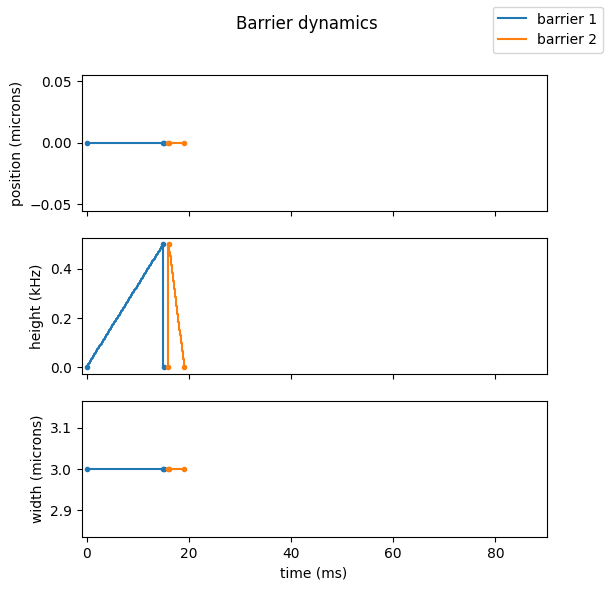

In [64]:
fs = FritschSoliton(qmf, 0.5, 2.0, 10.0)
fs_matter = fs.get_matter()
fs_matter.show_barrier_dynamics()

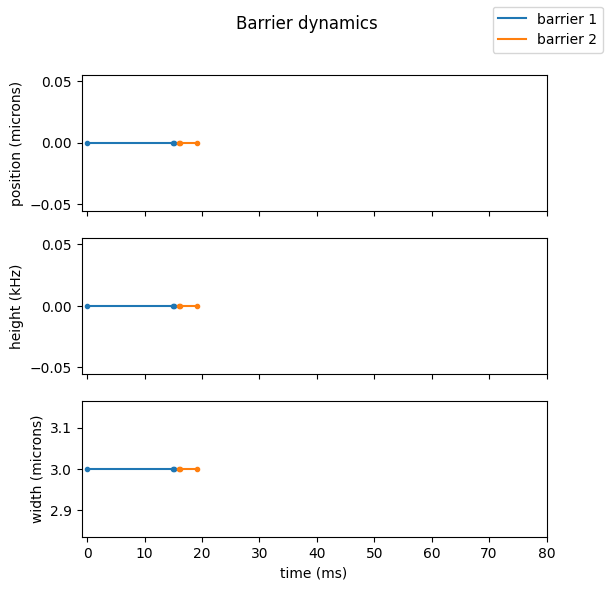

In [61]:
norm_matter = FritschSoliton(qmf, 0.0, 1.0, 0.0).get_matter()
norm_matter.show_barrier_dynamics()

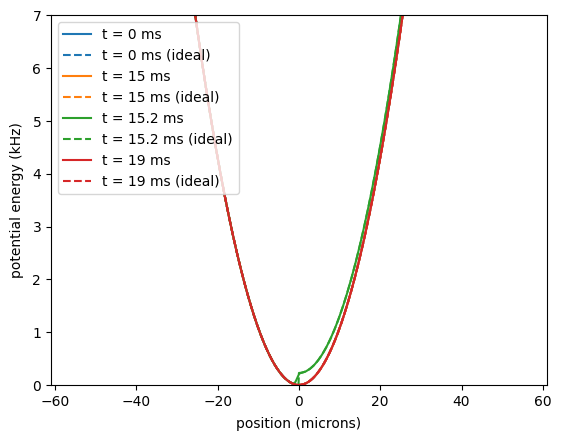

In [62]:
norm_matter.show_potential(times=[0, 15, 15.2, 19], include_ideal=True, ylimits=[0, 7])